# Twitter Sentiment Analysis - POC
---

## 7. Quickly train various models

**Current State**: I've trained three baseline models with little tweaking, fine-tuned a single decision tree, and trained a few random forests on a Bag-of-Word subset of $m\approx250k, n=50k$ of the training data, using cross validation, and got the following mean accuracy scores:

- Logistic Regression: $78.8\%$
- Random Forests: $78.5\%$
- Naive Bayes: $77.6\%$ 
- SGD (log loss): $77.1\%$ 
- Decision Tree: $69.0\%$

**This Notebook**: random forests are slow to build because they choose the best threshold for features at each node (as it chooses a subset of features for splitting). Extremely randomized trees (aka "Extra Trees") do not spend time and randomly choose a threshold, which trades more bias for a lower variance. This makes them a lot faster, but also less reliable, as we'll see when plotting learning curves. I decided to build some to see how well they perform.

**Feature Importances**: one aspect of using BoW and random forests that we've ignored is that we can extract feature importances with words attached to them, since features are words. This is perhaps the only good reason to use random forests. Unfortunately I didn't do this in the last notebook after 4 hours of training and didn't save the model so I lost those feature importances, but decided to plot some with the Extra Trees since they also return feature importances.

**Feature Selection**: one idea is to use feature importances from Extra Trees as a way to perform feature selection and re-run a good estimator on that smaller but most important set of features.

In [1]:
import re
import os
import time
import json

import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as plt

from sklearn.base import clone
from sklearn.ensemble import ExtraTreesClassifier 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

### Load $m\approx250k$, $n=50k$ training subset

In [2]:
proc_dir = os.path.join("..","data","3_processed","sentiment140")
X_train_transformed = sp.load_npz(os.path.join(proc_dir, "X_train_transformed_BoW_250k_50k.npz"))
with open(os.path.join(proc_dir, "y_array_250k.npy"), 'rb') as f:
    y_array = np.load(f)

In [3]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_transformed, 
                                                      y_array, 
                                                      test_size=0.2, 
                                                      random_state=42)

In [4]:
forest = ExtraTreesClassifier(n_estimators=100,
                              max_depth=5,
                              random_state=42,
                              bootstrap=True,
                              n_jobs=-1,
                              verbose=1)

In [5]:
forest.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.8s finished


ExtraTreesClassifier(bootstrap=True, max_depth=5, n_jobs=-1, random_state=42,
                     verbose=1)

In [6]:
y_pred = forest.predict(X_valid)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


In [7]:
round(accuracy_score(y_pred, y_valid), 4)

0.6464

In [8]:
scores = cross_val_score(forest, X_train_transformed, y_array, cv=3, scoring="accuracy", n_jobs=-1, verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   15.0s finished


In [9]:
round(scores.mean(),4)

0.6686

### Learning Curves

In [10]:
def plot_learning_curve(xs, train_acc, valid_acc):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_axes([0.0, X_train.shape[0], 0.4, 0.8])
    plt.plot(xs, train_acc, 'r--', linewidth=.8, label="train accuracy")
    plt.plot(xs, valid_acc, 'b--', linewidth=.8, label="validation accuracy")
    plt.xticks(rotation=45)
    plt.title(''.join(["Learning Rates for Training and Validation"]), fontsize=16)
    plt.legend(loc="lower right", fontsize=14)
    plt.xlabel("Training Set Size", fontsize=14)
    plt.ylabel("Accuracy", fontsize=14)
    plt.show()

In [11]:
forest = ExtraTreesClassifier(n_estimators=100,
                              max_depth=5,
                              random_state=42,
                              bootstrap=False, # changed to entire dataset
                              max_features="sqrt", # default made explicit
                              max_samples=None, # default made explicit, feed m
                              n_jobs=-1,
                              verbose=0)

In [12]:
def train(forest, X_train, y_train, X_valid, y_valid):
    xs, train_acc, valid_acc, loop_ix = [], [], [], 0
    before_loop = time.time()
    for m_instances in range(1000, X_train.shape[0]+1000, 10000):
        loop_ix += 1
        start_loop = time.time()
        forest.fit(X_train[:m_instances], y_train[:m_instances])
        y_train_predict = forest.predict(X_train[:m_instances])
        y_valid_predict = forest.predict(X_valid)
        train_acc.append(accuracy_score(y_train[:m_instances], y_train_predict))
        valid_acc.append(accuracy_score(y_valid, y_valid_predict))
        xs.append(str(m_instances))
        loopmin,loopsec = divmod(time.time() - start_loop, 60)
        elapmin,elapsec = divmod(time.time() - before_loop, 60)  
        print(f'Loop {loop_ix:0.0f} | {m_instances:0.0f} instances | \
loop: {loopmin:0.0f}m{loopsec:0.0f}s | elapsed: {elapmin:0.0f}m{elapsec:0.0f}s')
    return xs, train_acc, valid_acc

In [13]:
forest = ExtraTreesClassifier(n_estimators=500,
                              max_depth=5,
                              random_state=42,
                              bootstrap=False, # change to entire dataset, opposite default from RandomForest
                              max_features="sqrt", # default made explicit
                              max_samples=None, # default made explicit, feed m
                              n_jobs=-1,
                              verbose=0)

In [14]:
xs, train_acc, valid_acc = train(forest, X_train, y_train, X_valid, y_valid)

Loop 1 | 1000 instances | loop: 0m3s | elapsed: 0m3s
Loop 2 | 11000 instances | loop: 0m3s | elapsed: 0m6s
Loop 3 | 21000 instances | loop: 0m5s | elapsed: 0m11s
Loop 4 | 31000 instances | loop: 0m7s | elapsed: 0m18s
Loop 5 | 41000 instances | loop: 0m9s | elapsed: 0m27s
Loop 6 | 51000 instances | loop: 0m11s | elapsed: 0m37s
Loop 7 | 61000 instances | loop: 0m13s | elapsed: 0m50s
Loop 8 | 71000 instances | loop: 0m15s | elapsed: 1m5s
Loop 9 | 81000 instances | loop: 0m18s | elapsed: 1m23s
Loop 10 | 91000 instances | loop: 0m20s | elapsed: 1m43s
Loop 11 | 101000 instances | loop: 0m22s | elapsed: 2m5s
Loop 12 | 111000 instances | loop: 0m25s | elapsed: 2m30s
Loop 13 | 121000 instances | loop: 0m27s | elapsed: 2m56s
Loop 14 | 131000 instances | loop: 0m30s | elapsed: 3m26s
Loop 15 | 141000 instances | loop: 0m32s | elapsed: 3m59s
Loop 16 | 151000 instances | loop: 0m34s | elapsed: 4m32s
Loop 17 | 161000 instances | loop: 0m37s | elapsed: 5m9s
Loop 18 | 171000 instances | loop: 0m39s | e

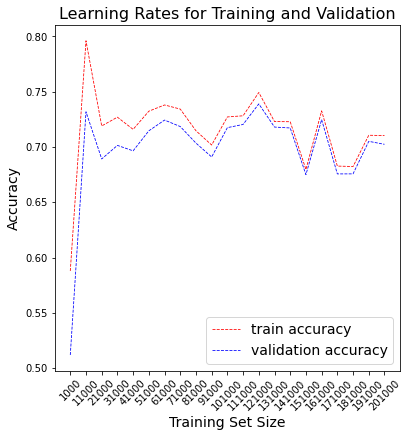

In [15]:
plot_learning_curve(xs, train_acc, valid_acc)

In [16]:
forest = ExtraTreesClassifier(n_estimators=500,
                              max_depth=5,
                              random_state=42,
                              bootstrap=False, # changed to entire dataset
                              max_features=1000, # increase number of features
                              max_samples=None, # default made explicit, feed m
                              n_jobs=-1,
                              verbose=0)

In [17]:
xs, train_acc, valid_acc = train(forest, X_train, y_train, X_valid, y_valid)

Loop 1 | 1000 instances | loop: 0m2s | elapsed: 0m2s
Loop 2 | 11000 instances | loop: 0m5s | elapsed: 0m8s
Loop 3 | 21000 instances | loop: 0m9s | elapsed: 0m17s
Loop 4 | 31000 instances | loop: 0m14s | elapsed: 0m31s
Loop 5 | 41000 instances | loop: 0m19s | elapsed: 0m50s
Loop 6 | 51000 instances | loop: 0m25s | elapsed: 1m15s
Loop 7 | 61000 instances | loop: 0m30s | elapsed: 1m45s
Loop 8 | 71000 instances | loop: 0m37s | elapsed: 2m22s
Loop 9 | 81000 instances | loop: 0m44s | elapsed: 3m6s
Loop 10 | 91000 instances | loop: 0m51s | elapsed: 3m57s
Loop 11 | 101000 instances | loop: 0m58s | elapsed: 4m55s
Loop 12 | 111000 instances | loop: 1m3s | elapsed: 5m58s
Loop 13 | 121000 instances | loop: 1m11s | elapsed: 7m9s
Loop 14 | 131000 instances | loop: 1m18s | elapsed: 8m28s
Loop 15 | 141000 instances | loop: 1m26s | elapsed: 9m54s
Loop 16 | 151000 instances | loop: 1m32s | elapsed: 11m25s
Loop 17 | 161000 instances | loop: 1m39s | elapsed: 13m4s
Loop 18 | 171000 instances | loop: 1m26s 

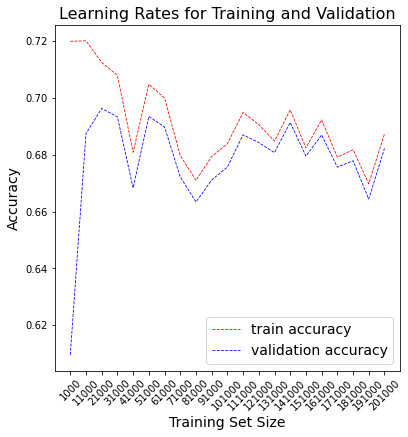

In [18]:
plot_learning_curve(xs, train_acc, valid_acc)

In [19]:
forest = ExtraTreesClassifier(n_estimators=1000, # increase number of trees
                              max_depth=5,
                              random_state=42,
                              bootstrap=False, # changed to entire dataset
                              max_features="sqrt", # default made explicit
                              max_samples=None, # default made explicit, feed m
                              n_jobs=-1,
                              verbose=0)

In [20]:
xs, train_acc, valid_acc = train(forest, X_train, y_train, X_valid, y_valid)

Loop 1 | 1000 instances | loop: 0m2s | elapsed: 0m2s
Loop 2 | 11000 instances | loop: 0m4s | elapsed: 0m6s
Loop 3 | 21000 instances | loop: 0m6s | elapsed: 0m11s
Loop 4 | 31000 instances | loop: 0m8s | elapsed: 0m19s
Loop 5 | 41000 instances | loop: 0m10s | elapsed: 0m29s
Loop 6 | 51000 instances | loop: 0m13s | elapsed: 0m42s
Loop 7 | 61000 instances | loop: 0m15s | elapsed: 0m57s
Loop 8 | 71000 instances | loop: 0m18s | elapsed: 1m15s
Loop 9 | 81000 instances | loop: 0m21s | elapsed: 1m35s
Loop 10 | 91000 instances | loop: 0m24s | elapsed: 1m59s
Loop 11 | 101000 instances | loop: 0m26s | elapsed: 2m25s
Loop 12 | 111000 instances | loop: 0m29s | elapsed: 2m54s
Loop 13 | 121000 instances | loop: 0m31s | elapsed: 3m25s
Loop 14 | 131000 instances | loop: 0m37s | elapsed: 4m2s
Loop 15 | 141000 instances | loop: 0m39s | elapsed: 4m41s
Loop 16 | 151000 instances | loop: 0m42s | elapsed: 5m23s
Loop 17 | 161000 instances | loop: 0m45s | elapsed: 6m8s
Loop 18 | 171000 instances | loop: 0m47s |

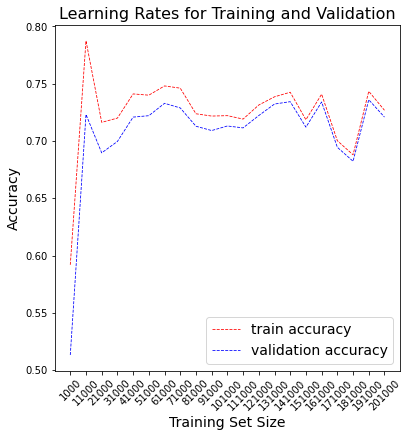

In [21]:
plot_learning_curve(xs, train_acc, valid_acc)

In [22]:
forest = ExtraTreesClassifier(n_estimators=1000, # increase number of trees
                              max_depth=50, # and increase their depth
                              random_state=42,
                              bootstrap=False, # changed to entire dataset
                              max_features="sqrt", # default made explicit
                              max_samples=None, # default made explicit, feed m
                              n_jobs=-1,
                              verbose=0)

In [23]:
xs, train_acc, valid_acc = train(forest, X_train, y_train, X_valid, y_valid)

Loop 1 | 1000 instances | loop: 0m8s | elapsed: 0m8s
Loop 2 | 11000 instances | loop: 0m35s | elapsed: 0m43s
Loop 3 | 21000 instances | loop: 1m1s | elapsed: 1m44s
Loop 4 | 31000 instances | loop: 1m30s | elapsed: 3m14s
Loop 5 | 41000 instances | loop: 1m59s | elapsed: 5m14s
Loop 6 | 51000 instances | loop: 2m23s | elapsed: 7m37s
Loop 7 | 61000 instances | loop: 2m52s | elapsed: 10m29s
Loop 8 | 71000 instances | loop: 3m22s | elapsed: 13m51s
Loop 9 | 81000 instances | loop: 3m53s | elapsed: 17m44s
Loop 10 | 91000 instances | loop: 4m25s | elapsed: 22m9s
Loop 11 | 101000 instances | loop: 4m55s | elapsed: 27m3s
Loop 12 | 111000 instances | loop: 5m32s | elapsed: 32m35s
Loop 13 | 121000 instances | loop: 5m56s | elapsed: 38m31s
Loop 14 | 131000 instances | loop: 6m29s | elapsed: 45m0s
Loop 15 | 141000 instances | loop: 7m19s | elapsed: 52m19s
Loop 16 | 151000 instances | loop: 7m50s | elapsed: 60m10s
Loop 17 | 161000 instances | loop: 8m50s | elapsed: 68m59s
Loop 18 | 171000 instances | 

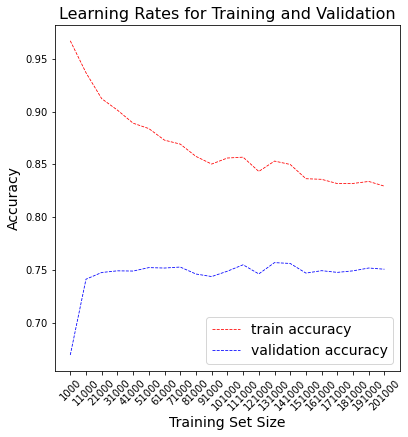

In [24]:
plot_learning_curve(xs, train_acc, valid_acc)

Finally a model that is a bit more stable, so tree depth probably helps stabilize the algorithm, however, validation accuracies are somewhat low and settling around 75-76% max.

In [25]:
df = pd.DataFrame(
    {'instances': xs,
     'validation accuracy': valid_acc,
     'train accuracy': train_acc
    })

df.sort_values(by=['validation accuracy'], ascending=False).head()

,instances,validation accuracy,train accuracy
13,131000,0.756810,0.853023
14,141000,0.756015,0.849823
11,111000,0.754762,0.856730
7,71000,0.752615,0.869113
5,51000,0.752078,0.883824


### Feature importances

The forest of trees consist of estimators instantiated with varying random states:

In [26]:
forest.estimators_[:5]

[ExtraTreeClassifier(max_depth=50, max_features='sqrt', random_state=1608637542),
 ExtraTreeClassifier(max_depth=50, max_features='sqrt', random_state=1273642419),
 ExtraTreeClassifier(max_depth=50, max_features='sqrt', random_state=1935803228),
 ExtraTreeClassifier(max_depth=50, max_features='sqrt', random_state=787846414),
 ExtraTreeClassifier(max_depth=50, max_features='sqrt', random_state=996406378)]

Given this variability in estimators, we get the std for the feature importances for each, to plot error bars, and get the reverse sorted indices to slice the data for plotting later on.

In [27]:
# get standard deviations from all the forest estimators
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

# sort (in reverse) the indices for the feature importances
indices = np.argsort(forest.feature_importances_)[::-1]

One challenge is to retrieve our vocabulary from the original data, which needs to be traced all the way back to the raw data. The disadvantage of using `Pipeline` for both transformers calling the `fit_transform` methods is that we lose our vocabulary, which is only built with the `fit` method in the **WordCounterToVectorTransformer** class.

In [28]:
# load minimally prepared X, y train subsets
raw_path = os.path.join("..","data","1_raw","sentiment140")
X_train = pd.read_csv(os.path.join(raw_path, "X_train.csv"))
y_train = pd.read_csv(os.path.join(raw_path, "y_train.csv"))

# split into 250k subset and discard rest
X, X_rest, y, y_rest = train_test_split(X_train, y_train, test_size=0.79, random_state=42)

# transform into arrays
X_array = np.array(X.iloc[:, 2]).ravel()
y_array = y.iloc[:,0].ravel()

import cleanup_module_POC as Cmod

docword_transformer = Cmod.DocumentToWordCounterTransformer()
wordvec_transformer = Cmod.WordCounterToVectorTransformer(vocabulary_size=50000)

# fit_transform the doc to word counter transformer
X_array_transformed = docword_transformer.fit_transform(X_array)

# only fit the word vector transformer to get the vocabulary
X_transformed = wordvec_transformer.fit(X_array_transformed)

In [29]:
print("Feature ranking:")
for i in range(15):
    print("%d. feature %d %s (%0.4f)" % (i+1, 
                                        indices[i],
                                        [w for w, ix in X_transformed.vocabulary_.items() if ix == indices[i]][0],
                                        forest.feature_importances_[indices[i]]))

Feature ranking:
1. feature 2 USERNAME (0.0675)
2. feature 63 thanks (0.0230)
3. feature 6 not (0.0206)
4. feature 1 i (0.0200)
5. feature 67 miss (0.0143)
6. feature 85 wish (0.0113)
7. feature 87 sad (0.0107)
8. feature 99 sorry (0.0096)
9. feature 5 you (0.0078)
10. feature 11 but (0.0077)
11. feature 4 my (0.0073)
12. feature 95 bad (0.0073)
13. feature 166 suck (0.0072)
14. feature 18 good (0.0067)
15. feature 316 poor (0.0064)


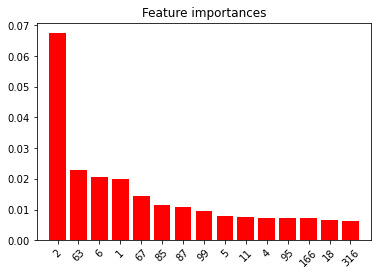

In [30]:
# plot feature importances
plt.figure()
plt.title("Feature importances")
plt.bar(range(15), forest.feature_importances_[indices[:15]],
        color="r")#, yerr=std[indices[:15]], align="center")
plt.xticks(range(15), indices[:15])
plt.xlim([-1, 15])
plt.xticks(rotation=45)
plt.show()

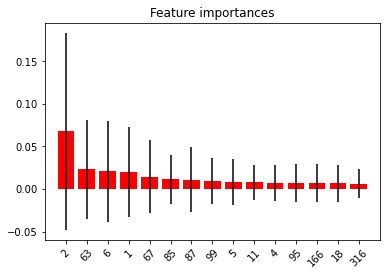

In [31]:
# plot the uncertainty/variability around the feature importances
# which is understandably large in Extra Trees
plt.figure()
plt.title("Feature importances")
plt.bar(range(15), forest.feature_importances_[indices[:15]],
        color="r", yerr=std[indices[:15]], align="center")
plt.xticks(range(15), indices[:15])
plt.xlim([-1, 15])
plt.xticks(rotation=45)
plt.show()

### Feature Selection

In [35]:
X_indices[:224] # sqrt(n_features) of most important features

array([   2,   63,    6,    1,   67,   85,   87,   99,    5,   11,    4,
         95,  166,   18,  316,   28,   27,  119,  136,  200,  161,   71,
         45,  367,   21,  244,  111,   25,   30,   48,  139,  216,   98,
         78,    8,  233,  322,  271,  152,   57,   94,  122,  781,  595,
        525,  401,  340,  700,  257,  219,  118,  142,    7,  303,   38,
         81,  585,   13,  580,  130,  164,  956,  718,  133,  371,   60,
        560,  214,   49,  177,  218,  696,   24,   73,  146,  149,    9,
        372, 1015,   97,  677,   59,  224,   10,  190,  326,  474,  490,
         93,  377,  116,   16,  185,  128,  434,  301,  733,  345,  683,
        350,  124,  450,  475,   41,  294,    0,   62,   88,  344,  759,
        180, 1209,   19,  992,    3,  208,  140,  411,   39,   31,  473,
        172,   43,  108,  608,  286,  583,  366,  877, 1116,  483,  280,
        342,  831,  320,  749,  186,  849,   89,  394,  514,  211,   80,
       1077,  633,   15,   53,   44,   79,  596,  4

In [63]:
forest = ExtraTreesClassifier(n_estimators=500, # moderate size
                              max_depth=50, # deep
                              random_state=42,
                              bootstrap=False, # changed to entire dataset
                              max_features="sqrt", # default made explicit
                              max_samples=10000, 
                              n_jobs=-1,
                              verbose=2)

In [64]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_transformed, 
                                                      y_array, 
                                                      test_size=0.2, 
                                                      random_state=42)

In [75]:
#forest.fit(X_train[:,indices[:224]], y_train) 8.9 min

In [76]:
y_pred = forest.predict(X_valid[:,indices[:224]])

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    1.9s finished


In [77]:
round(accuracy_score(y_pred, y_valid), 4)

0.7426

In [78]:
# persist indices
model_dir = os.path.join("..","data","4_models","sentiment140")
with open(os.path.join(model_dir, "POC9_feature_importances.npy"), 'wb') as f:
    np.save(f, indices)

---